Data analysis

Number of categories:  10
Number of training samples:  50000


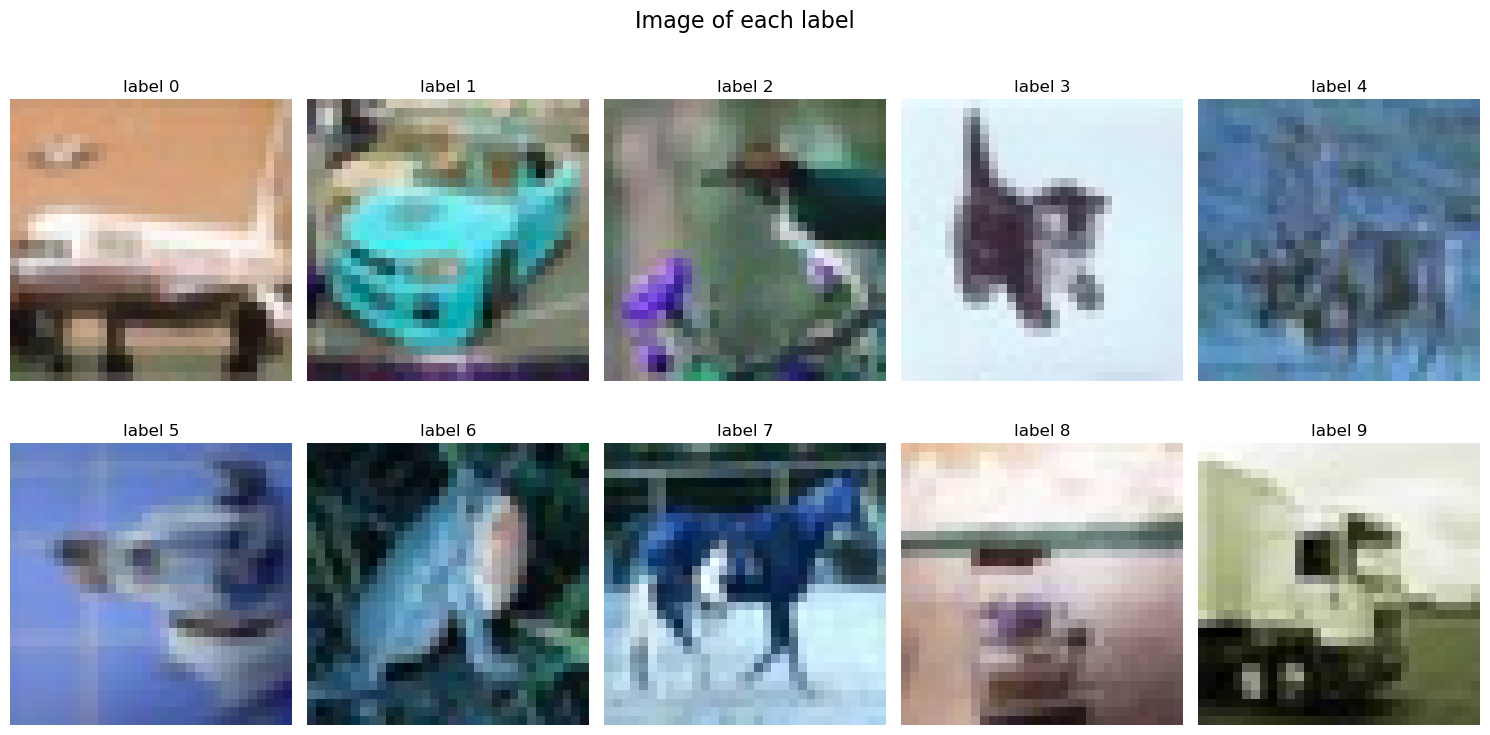

In [2]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# load the data
data_dir = os.getcwd()
test_images_dir = os.path.join(data_dir, 'test_ims')
train_images_dir = os.path.join(data_dir, 'train_ims')

train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))

category_counts = train_df['label'].value_counts().sort_index()
num_categories = train_df['label'].nunique()

print("Number of categories: ", num_categories)
print("Number of training samples: ", len(train_df))

# Display images of each label
example_images = {}
unique_labels = sorted(train_df['label'].unique())
for label in unique_labels:
    sample_row = train_df[train_df['label'] == label].iloc[0]
    im_name = sample_row['im_name']

    image_path = os.path.join(train_images_dir, im_name)
    if os.path.exists(image_path):
        example_images[label] = image_path
    else:
        print(f"Image not found: {image_path}")
        continue

nrows, ncols = 2, 5
plt.figure(figsize=(3 * ncols, 4 * nrows))

for i, label in enumerate(unique_labels):
    plt.subplot(nrows, ncols, i + 1)
    if label in example_images:
        img = Image.open(example_images[label])
        plt.imshow(img)
        plt.title(f"label {label}")
    else:
        plt.text(0.5, 0.5, "no image", ha='center', va='center')
    plt.axis('off')

plt.suptitle("Image of each label", fontsize=16)
plt.tight_layout()
plt.show()

Data processing

In [4]:
from sklearn.model_selection import train_test_split

IMG_SIZE = (16,16)

# Initialize lists to hold image data and labels
X = []  # Feature vectors (flattened grayscale images)
y = []  # Labels

for idx, row in train_df.iterrows():
    im_name = row['im_name']
    label = row['label']
    image_path = os.path.join(train_images_dir, im_name)
    
    try:
        img_gray = cv2.imread(image_path,cv2.IMREAD_COLOR_RGB)
        img_gray = cv2.resize(img_gray, IMG_SIZE)
        X.append(img_gray)
        y.append(label)
    except:
        raise Exception(f"Image {im_name} does not exist.")

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print(X_train.shape)

(45000, 16, 16, 3)


In [37]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys',
                 channel_axis=None):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
        self.channel_axis = channel_axis
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm,
                       channel_axis=self.channel_axis)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

hogify = HogTransformer(
    pixels_per_cell=(16, 16), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys',
    channel_axis=2
)
scl = StandardScaler()
X_train_hogify = hogify.fit_transform(X_train)
X_train_prepared = scl.fit_transform(X_train_hogify)
X_test_hogify = hogify.fit_transform(X_test)
X_test_prepared = scl.fit_transform(X_test_hogify)
X_train_hogify.shape, X_test_prepared.shape
        

((45000, 1764), (5000, 1764))

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

sgd = SVC(C=50.0, kernel='rbf', random_state=42)
sgd.fit(X_train_prepared, y_train)

print("fit finished")

y_train_pred = sgd.predict(X_train_prepared)
y_test_pred = sgd.predict(X_test_prepared)

print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

In [ ]:
X_final = []  # Feature vectors (flattened grayscale images)
y_final = []  # Labels

for idx, row in test_df.iterrows():
    im_name = row['im_name']
    label = row['label']
    image_path = os.path.join(test_images_dir, im_name)
    
    try:
        img_gray = cv2.imread(image_path,cv2.IMREAD_COLOR_RGB)
        # img_gray = cv2.resize(img_gray, IMG_SIZE)
        X_final.append(img_gray)
        y_final.append(label)
    except:
        raise Exception(f"Image {im_name} does not exist.")

X_final = np.array(X_final)
y_final = np.array(y_final)

X_final_hogify = hogify.fit_transform(X_final)
X_final_prepared = scl.fit_transform(X_final_hogify)
print(X_final_prepared.shape)

y_final_pred = sgd.predict(X_final_prepared)
accuracy_score(y_final, y_final_pred)

Train SVM classifier and Random Forest classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
import time

svm = SVC(C=1,kernel="rbf")
ada = AdaBoostClassifier(estimator=svm, n_estimators=10, learning_rate=0.1)

time1 = time.time()
ada = ada.fit(X_train, y_train)
time2 = time.time()
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(y_test)

ada_test = accuracy_score(y_test, y_test_pred)
print(ada_test)
print(time2-time1)